# Project 11 - Object Detection using the pre-trained model "inception_resnet_v2" from tensorflow_hub

In [1]:
# importing packages
# For running inference on the TF-Hub module. tensorflow_hub: a repo for all the pre-trained models
import tensorflow as tf
import tensorflow_hub as hub
 
import matplotlib.pyplot as plt

# temporary buffer for image download
import tempfile

# url request handler for image download
from six.moves.urllib.request import urlopen

# input/output buffer handler
from six import BytesIO
 
# For drawing overlay boxes on the image.
# PIL - Python Imaging Library, for loading, opening, manipulating image files 
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
 
# For measuring the inference time.
import time

In [2]:
# Print Tensorflow version
print(tf.__version__)
 
# Check available GPU devices.
if tf.config.list_physical_devices('GPU') != []:
    print("\nThe following GPU devices are available: %s" %(tf.test.gpu_device_name()))
else:
    print("\nNo GPU available, CPU is being used instead")

2.5.0

The following GPU devices are available: /device:GPU:0


In [3]:
# function to invoke and display an image
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [4]:
# function for downloading and resizing an image

def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response    = urlopen(url)
    image_data  = response.read()
    image_data  = BytesIO(image_data)
    pil_image   = Image.open(image_data)
    pil_image   = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename
    

In [5]:
# function Adds a bounding box to an image

def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color,font,thickness=4,display_str_list=()): 
    draw = ImageDraw.Draw(image)
    im_width, im_height        = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, 
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top),(left, bottom),(right, bottom),(right, top),(left, top)],
              width=thickness,
              fill=color)
    
    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin
 

In [6]:
# Overlay labeled boxes on an image with formatted scores and label names.

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()
    
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image


Image downloaded to /tmp/tmpbspai17e.jpg.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


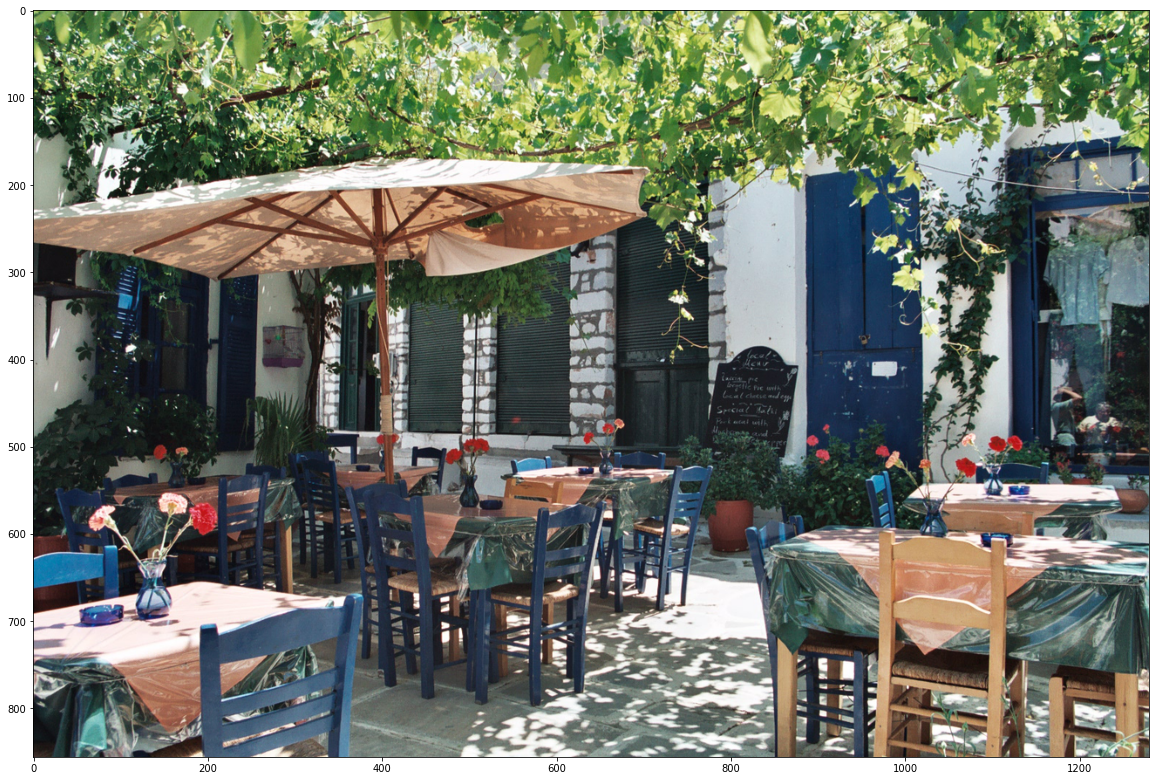

In [7]:
# image Source : https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg

image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True) # display=True, to show the downloaded and resized image

# using the pre-trained model "inception_resnet_v2" from tensorflow_hub 
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

# loading the pre-trained model from the url
detector = hub.load(module_handle).signatures['default']


In [24]:

# function to load the image
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

# function to run the object detector and display the marked objects on the image
def run_detector(detector, path):
    img = load_img(path)
    
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time     = time.time()
    result         = detector(converted_img)
    end_time       = time.time()
    
    result = {key:value.numpy() for key,value in result.items()}
    
    print("-----------------------------------------------------------")
    print(f"Found {len(result['detection_class_names'])} objects.")
    print("Inference time: ", end_time-start_time)
    print("-----------------------------------------------------------")
    
    image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"],
                                  result["detection_class_entities"], result["detection_scores"])
    display_image(image_with_boxes)



-----------------------------------------------------------
Found 100 objects.
Inference time:  1.318843126296997
-----------------------------------------------------------


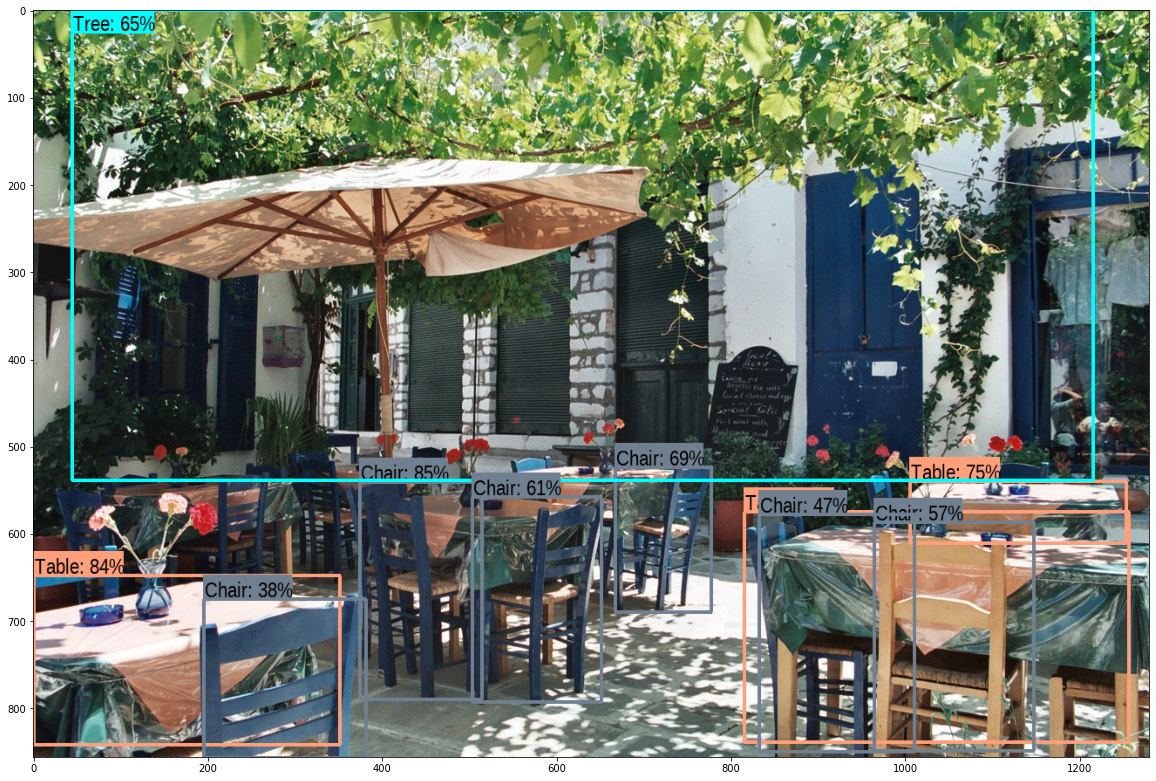

In [25]:
# Execting the detector function

run_detector(detector, downloaded_image_path)

In [26]:
# List of few more images for object detection

image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
]

# loading the images from the url
def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)


Image downloaded to /tmp/tmpvtzvut_x.jpg.
-----------------------------------------------------------
Found 100 objects.
Inference time:  1.2767765522003174
-----------------------------------------------------------
Inference time: 1.5574102401733398


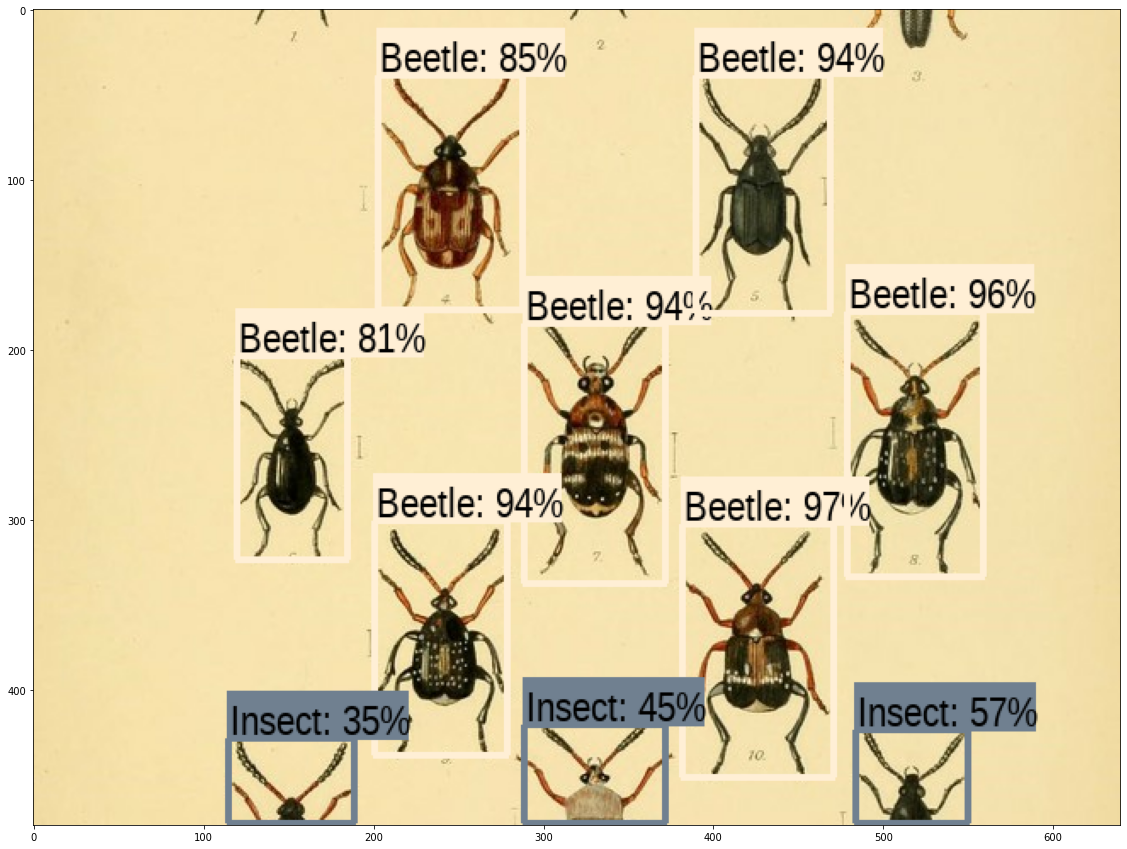

In [27]:
# running object detection on the first image from the list
detect_img(image_urls[0])


Image downloaded to /tmp/tmpcoeepbfa.jpg.
-----------------------------------------------------------
Found 100 objects.
Inference time:  1.2212512493133545
-----------------------------------------------------------
Inference time: 1.5781159400939941


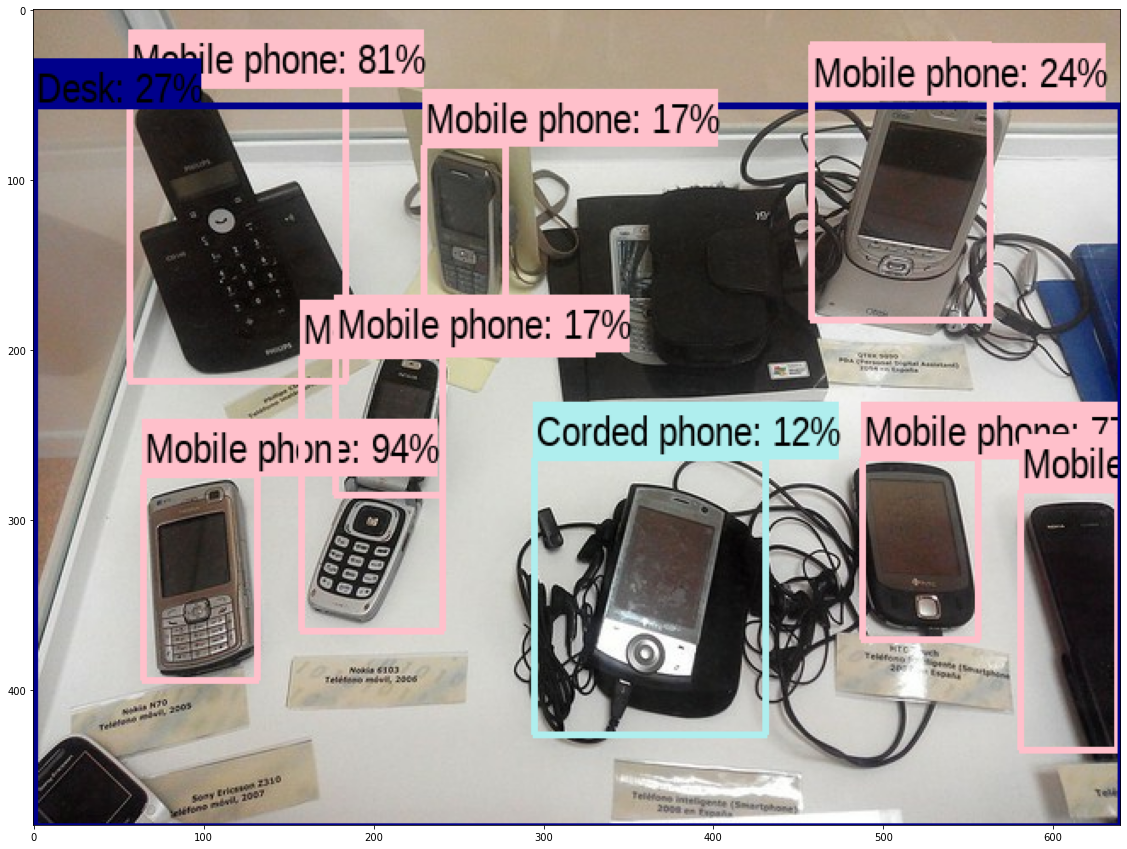

In [28]:
# running object detection on the second image from the list
detect_img(image_urls[1])


Image downloaded to /tmp/tmpz_xr1ujs.jpg.
-----------------------------------------------------------
Found 100 objects.
Inference time:  1.2227237224578857
-----------------------------------------------------------
Inference time: 1.6959753036499023


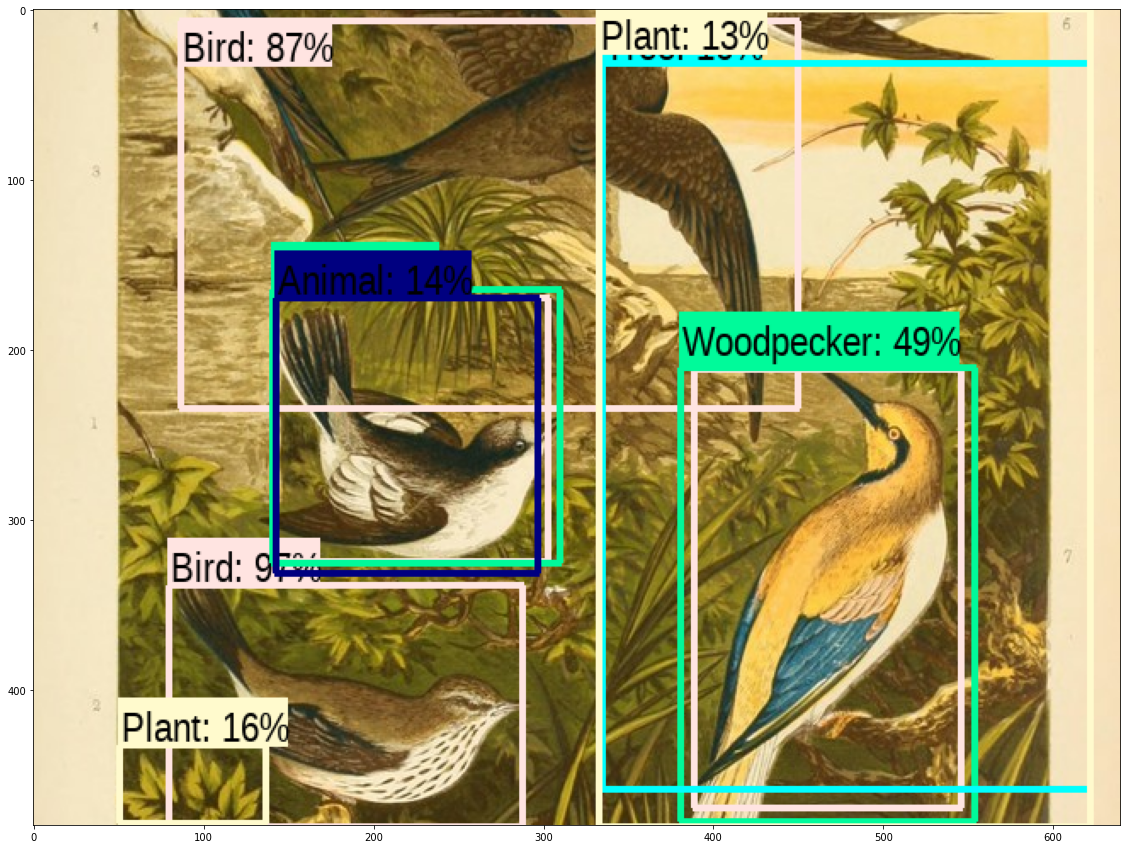

In [29]:
# running object detection on the last image from the list
detect_img(image_urls[2])


Image downloaded to /tmp/tmp9afgkofw.jpg.
-----------------------------------------------------------
Found 100 objects.
Inference time:  1.246290922164917
-----------------------------------------------------------
Inference time: 1.3970725536346436


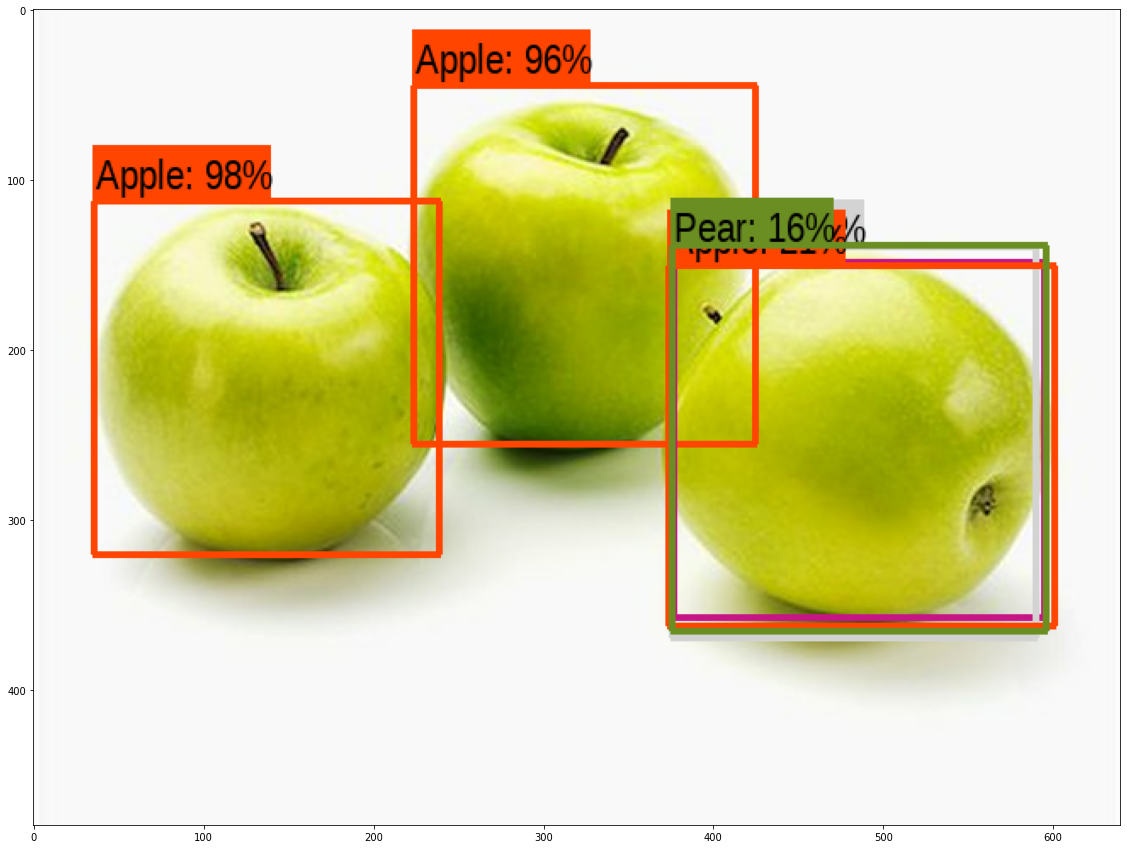

In [30]:

# running object detection on a random image
detect_img("https://image1.masterfile.com/getImage/NjU5LTA2NjcxNjE3ZW4uMDAwMDAwMDA=AAfl1g/659-06671617en_Masterfile.jpg")